# Import and preparation

## Import

In [5]:
import requests
import pandas as pd
from io import StringIO
import gdown

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# !pip install --upgrade pip
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


import jax.numpy as jnp
import jax
import optax
import scipy

import matplotlib as mpl
import os
import warnings



# !pip install -U dm-haiku
import haiku as hk
rng_seq = hk.PRNGSequence(np.random.randint(2**32))

In [6]:
import jax
# 这行会打印出可用的设备，应该至少能看到一个 GpuDevice
print("Available JAX devices:", jax.devices())


Available JAX devices: [CudaDevice(id=0)]


In [7]:
# try:
#     from google.colab import files
#     _ON_COLAB = True
# except:
#     _ON_COLAB = False

# if _ON_COLAB:
#   !rm -rf CogModelingRNNsTutorial
#   !git clone https://github.com/YifeiCAO/CogModelingRNNsTutorial
#   !pip install -e CogModelingRNNsTutorial/CogModelingRNNsTutorial
#   !cp CogModelingRNNsTutorial/CogModelingRNNsTutorial/*py CogModelingRNNsTutorial
# else:
#   !pip install CogModelingRNNsTutorial/requirements.txt

# %load_ext autoreload
# %autoreload 2

# import haiku as hk
# import jax
# import jax.numpy as jnp

# warnings.filterwarnings("ignore")

# try:
#     from google.colab import files
#     _ON_COLAB = True
# except:
#     _ON_COLAB = False

from CogModelingRNNsTutorial.CogModelingRNNsTutorial import bandits
from CogModelingRNNsTutorial.CogModelingRNNsTutorial import disrnn
from CogModelingRNNsTutorial.CogModelingRNNsTutorial import hybrnn
from CogModelingRNNsTutorial.CogModelingRNNsTutorial import hybconrnn
from CogModelingRNNsTutorial.CogModelingRNNsTutorial import hybrnn_direct_con
from CogModelingRNNsTutorial.CogModelingRNNsTutorial import plotting
from CogModelingRNNsTutorial.CogModelingRNNsTutorial import rat_data
from CogModelingRNNsTutorial.CogModelingRNNsTutorial import rnn_utils

## Downloading Data for different species

### Monkey Data Download and tidy

In [4]:
# Monkey dataset from Hua Tang, Bartolo
import gdown

# downlowd link for Google Drive
file_id_tang = '1HqQxA2uIz6C2Eq-51rhrkFj0DMoS25RW'
url_tang = f'https://drive.google.com/uc?id={file_id_tang}'
output_tang = 'hua_tang_data.csv'
gdown.download(url_tang, output_tang, quiet=False)
monkey_data = pd.read_csv(output_tang)

# 为每个 (monkey, date, blockIndex) 内生成 trial_id，从0递增
monkey_data['trial_id'] = monkey_data.groupby(['monkey', 'date', 'blockIndex']).cumcount()

# 操作1：每只猴子按照日期从早到晚编码
monkey_data['date'] = pd.to_datetime(monkey_data['date'], format='%Y%m%d')
monkey_data.sort_values(by=['monkey', 'date'], inplace=True)

monkey_data['date'] = monkey_data.groupby('monkey')['date'].rank(method='dense').astype(int)

# 操作2：根据blockType创建新变量action
monkey_data['action'] = monkey_data.apply(lambda x: x['trialObject'] if x['blockType'] == 1 else x['trialDirection'], axis=1)

# 创建 session key
monkey_data['session_key'] = monkey_data[['monkey', 'date', 'blockIndex']].astype(str).agg('-'.join, axis=1)

# 编号 session，从1开始
monkey_data['session'] = monkey_data['session_key'].astype('category').cat.codes + 1

# 可选：删除临时变量
monkey_data = monkey_data.drop(columns='session_key')

# Dataset Shape information
n_participants_monkey = 2
n_trials_monkey = 80
n_bandits_monkey = 2
min_points_monkey = 1
max_points_monkey = 0

#Creates one hot code for actions
action_cols = ['action_{}'.format(i) for i in range(2)]  # this creates the following vector: 'action_0', 'action_1', 'action_2', 'action_3']
monkey_data[action_cols] = jax.nn.one_hot(jnp.array(monkey_data['action']), 2)

#Generate dataset for training, validation
def generate_action_n(group):
    group['action_n'] = group['action'].shift(-1)  # 将 action 列向上移动一行
    group['action_n'].iloc[-1] = -1  # 将每个组的最后一个值设为 -1
    return group

# 按 participant 分组并应用函数
monkey_data = monkey_data.groupby(['session']).apply(generate_action_n)
monkey_data = monkey_data.reset_index(drop=True)

# ✅ 删除 trial 数不足 80 的 session
session_lengths = monkey_data['session'].value_counts()
valid_sessions = session_lengths[session_lengths >= 80].index
monkey_data = monkey_data[monkey_data['session'].isin(valid_sessions)]

monkey_rnn = monkey_data.sort_values(by=['session','trial_id'])

# 提取action和reward列并转换为numpy数组
seq_rnn = monkey_rnn[['action', 'reward','action_n']]

import numpy as np

# 确保 monkey_rnn 是按 session 和 trial_id 排好序的
monkey_rnn = monkey_data.sort_values(by=['session', 'trial_id'])

# 获取所有 session 的 id（已经筛选为 trial 数 >= 80）
session_ids = monkey_rnn['session'].unique()

# 初始化空列表
xs_list = []
ys_list = []

# 遍历每个 session
for session_id in session_ids:
    session_data = monkey_rnn[monkey_rnn['session'] == session_id]

    # 只保留前 80 个 trial（确保一致）
    session_data = session_data.iloc[:80]

    x = session_data[['action', 'reward']].to_numpy().astype(float)  # shape (80, 2)
    y = session_data[['action_n']].to_numpy().astype(int)            # shape (80, 1)

    xs_list.append(x)
    ys_list.append(y)

# 堆叠为 numpy array，并转置成 (80, 190, 2) 以及 (80, 190, 1)
xs = np.stack(xs_list, axis=0)  # shape (80, n_sessions, 2)
ys = np.stack(ys_list, axis=0)  # shape (80, n_sessions, 1)

xs_t = np.stack(xs_list, axis=1)  # shape (80, n_sessions, 2)
ys_t = np.stack(ys_list, axis=1)  # shape (80, n_sessions, 1
#dataset_m_train, dataset_m_test, dataset_m_validate = rat_data.format_into_datasets(xs,ys, rnn_utils.DatasetRNN, 160, 15, 15)

Downloading...
From: https://drive.google.com/uc?id=1HqQxA2uIz6C2Eq-51rhrkFj0DMoS25RW
To: /teamspace/studios/this_studio/src/hua_tang_data.csv
100%|██████████| 363k/363k [00:00<00:00, 112MB/s]


In [5]:
monkey_rnn

,trialObject,trialDirection,blockType,blockIndex,reversal,reward,monkey,date,trial_id,action,session,action_0,action_1,action_n
0,0,0,2,1,0,0,V,1,0,0,1,1.0,0.0,1.0
1,1,1,2,1,0,0,V,1,1,1,1,0.0,1.0,1.0
2,1,1,2,1,0,0,V,1,2,1,1,0.0,1.0,1.0
3,0,1,2,1,0,0,V,1,3,1,1,0.0,1.0,0.0
4,1,0,2,1,0,1,V,1,4,0,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15370,1,1,1,9,1,1,w,4,75,1,195,0.0,1.0,1.0
15371,1,1,1,9,1,1,w,4,76,1,195,0.0,1.0,1.0
15372,1,1,1,9,1,1,w,4,77,1,195,0.0,1.0,1.0
15373,1,1,1,9,1,1,w,4,78,1,195,0.0,1.0,0.0


In [6]:
# 1. 取出所有 monkey_id
monkey_ids = monkey_rnn['monkey'].unique()  # -> array(['V','w'], dtype=object)

# 2. 为每只猴子分别构造 xs, ys
xs_by_monkey = {}
ys_by_monkey = {}

for m in monkey_ids:
    df_m = monkey_rnn[monkey_rnn['monkey'] == m]
    sess_ids = df_m['session'].unique()
    xs_list = []
    ys_list = []
    for sid in sess_ids:
        sub = (
            df_m[df_m['session'] == sid]
            .sort_values('trial_id')
            .iloc[:80]       # 保证每 session 最多 80 trials
        )
        x = sub[['action', 'reward']].to_numpy().astype(float)  # (80, 2)
        y = sub[['action_n']].to_numpy().astype(int)            # (80, 1)
        xs_list.append(x)
        ys_list.append(y)

    # 把 list 堆成 array，然后转置成 (timesteps, n_sessions, feat)
    arr_x = np.stack(xs_list, axis=0)  # (n_sessions_m, 80, 2)
    arr_y = np.stack(ys_list, axis=0)  # (n_sessions_m, 80, 1)
    xs_by_monkey[m] = arr_x.transpose(1, 0, 2)  # (80, n_sessions_m, 2)
    ys_by_monkey[m] = arr_y.transpose(1, 0, 2)  # (80, n_sessions_m, 1)

# 3. 拿到 V 和 w 两只猴子的 xs、ys
xs_V, ys_V = xs_by_monkey['V'], ys_by_monkey['V']
xs_w, ys_w = xs_by_monkey['w'], ys_by_monkey['w']

print("V:", xs_V.shape, ys_V.shape)
print("w:", xs_w.shape, ys_w.shape)


V: (80, 96, 2) (80, 96, 1)
w: (80, 94, 2) (80, 94, 1)


### Monkey data from Ioana dataset[link text](https://)

In [7]:
import gdown
import pandas as pd
import numpy as np

# 下载并读取 monkey_i_data
file_id_i = '1AWX5Kxy9CwD5nzxdsaoyYf-dxDI7LK0g'
url_i = f'https://drive.google.com/uc?id={file_id_i}'
output_i = 'monkey_i_data.csv'
gdown.download(url_i, output_i, quiet=False)
monkey_i_data = pd.read_csv(output_i)

# ✅ 复制并筛选掉 day <= 5 的 trial
df = monkey_i_data.copy()
df = df[df['day'] > 3].reset_index(drop=True)  # <-- 这里是关键

processed = []
global_session_id = 1

for day, group in df.groupby('day'):
    group = group.reset_index(drop=True)
    total_trials = len(group)
    max_trials = (total_trials // 80) * 80

    if max_trials == 0:
        continue

    group = group.iloc[:max_trials].copy()
    n_sessions = max_trials // 80
    group['session_id'] = (group.index // 80) + global_session_id
    group['trial_in_session'] = group.index % 80
    global_session_id += n_sessions
    processed.append(group)

final_df = pd.concat(processed, ignore_index=True)
monkey_i_data = final_df.copy()

#Generate dataset for training, validation
def generate_action_n(group):
    group['action_n'] = group['task_colour'].shift(-1)  # 将 action 列向上移动一行
    group['action_n'].iloc[-1] = -1  # 将每个组的最后一个值设为 -1
    return group

# 按 participant 分组并应用函数
monkey_i_data = monkey_i_data.groupby(['session_id']).apply(generate_action_n)
monkey_i_data = monkey_i_data.reset_index(drop=True)

monkey_i_rnn = monkey_i_data.sort_values(by=['session_id','trial_in_session'])

# 提取action和reward列并转换为numpy数组
seq_i_rnn = monkey_i_rnn[['task_colour', 'task_reward','action_n']]

# 获取所有 session 的 id（已经筛选为 trial 数 >= 80）
session_ids = monkey_i_rnn['session_id'].unique()

# 初始化空列表
xs_list = []
ys_list = []

# 遍历每个 session
for session_id in session_ids:
    session_data = monkey_i_rnn[monkey_i_rnn['session_id'] == session_id]

    # 只保留前 80 个 trial（确保一致）
    session_data = session_data.iloc[:80]

    x = session_data[['task_colour', 'task_reward']].to_numpy().astype(float)  # shape (80, 2)
    y = session_data[['action_n']].to_numpy().astype(int)            # shape (80, 1)

    xs_list.append(x)
    ys_list.append(y)

# 堆叠为 numpy array，并转置成 (80, 190, 2) 以及 (80, 190, 1)
xs = np.stack(xs_list, axis=0)  # shape (80, n_sessions, 2)
ys = np.stack(ys_list, axis=0)  # shape (80, n_sessions, 1)

xs_i = np.stack(xs_list, axis=1)  # shape (80, n_sessions, 2)
ys_i = np.stack(ys_list, axis=1)  # shape (80, n_sessions, 1)

#dataset_m_train, dataset_m_test, dataset_m_validate = rat_data.format_into_datasets(xs,ys, rnn_utils.DatasetRNN, 120, 10, 10)

Downloading...
From: https://drive.google.com/uc?id=1AWX5Kxy9CwD5nzxdsaoyYf-dxDI7LK0g
To: /teamspace/studios/this_studio/src/monkey_i_data.csv
100%|██████████| 899k/899k [00:00<00:00, 91.3MB/s]


### Mice data download and tidy

In [13]:
# # ✅ 使用新的文件 ID
# file_id = '1yEVGt8kk1RRkA4VUl80lYolSZ_EmB-zJ'
# download_url = f'https://drive.google.com/uc?id={file_id}'

# # ✅ 指定下载后的文件名
# output_file = 'downloaded_file.csv'
# gdown.download(download_url, output_file, quiet=False)
# mice_data = pd.read_csv(output_file)

# # 操作1：每只猴子按照日期从早到晚编码
# mice_data['date'] = pd.to_datetime(mice_data['date'])  # 自动识别格式
# mice_data.sort_values(by=['subject', 'date', 'trial'], inplace=True)

# mice_data['date'] = mice_data.groupby('subject')['date'].rank(method='dense').astype(int)

# # 将 choice 中的 'L' 替换为 0，'R' 替换为 1
# mice_data['action'] = mice_data['choice'].map({'L': 0, 'R': 1})

# # 创建 session key
# mice_data['session_key'] = mice_data[['subject', 'date']].astype(str).agg('-'.join, axis=1)

# # 编号 session，从1开始
# mice_data['session'] = mice_data['session_key'].astype('category').cat.codes + 1

# # 可选：删除临时变量
# mice_data = mice_data.drop(columns='session_key')

# # Dataset Shape information
# n_participants_mice = 10
# #n_trials_monkey = 80
# n_bandits_mice = 2
# min_points_mice = 1
# max_points_mice = 0

# #Creates one hot code for actions
# action_cols = ['action_{}'.format(i) for i in range(2)]  # this creates the following vector: 'action_0', 'action_1', 'action_2', 'action_3']
# mice_data[action_cols] = jax.nn.one_hot(jnp.array(mice_data['action']), 2)

# #Generate dataset for training, validation
# def generate_action_n(group):
#     group['action_n'] = group['action'].shift(-1)  # 将 action 列向上移动一行
#     group['action_n'].iloc[-1] = -1  # 将每个组的最后一个值设为 -1
#     return group

# # 按 participant 分组并应用函数
# mice_data = mice_data.groupby(['session']).apply(generate_action_n)
# mice_data = mice_data.reset_index(drop=True)

# mice_rnn = mice_data.sort_values(by=['session','trial'])

# # 提取action和reward列并转换为numpy数组
# seq_rnn = mice_rnn[['action', 'rewarded','action_n']]

# # Step 1: 获取所有 session 的最大长度
# max_len = mice_rnn.groupby('session').size().max()

# # Step 2: 初始化容器
# xs_padded = []
# ys_padded = []
# mask_padded = []

# # Step 3: 遍历每个 session 并填充
# for _, session_df in mice_rnn.groupby('session'):
#     x = session_df[['action', 'rewarded']].values.astype(float)
#     y = session_df[['action_n']].values.astype(int)

#     pad_len = max_len - len(x)

#     # Padding：action/reward = 0，action_n = -1（表示无效）
#     x_padded = np.pad(x, ((0, pad_len), (0, 0)), constant_values=0)
#     y_padded = np.pad(y, ((0, pad_len), (0, 0)), constant_values=-1)

#     # 生成 mask（有效部分 = 1，padding = 0）
#     mask = np.pad(np.ones(len(x)), (0, pad_len), constant_values=0)

#     xs_padded.append(x_padded)
#     ys_padded.append(y_padded)
#     mask_padded.append(mask)

# # 转为 numpy 数组
# xs_array = np.stack(xs_padded)       # shape: (n_sessions, max_len, 2)
# ys_array = np.stack(ys_padded)       # shape: (n_sessions, max_len, 1)
# mask_array = np.stack(mask_padded)   # shape: (n_sessions, max_len)

# dataset_r_train, dataset_r_test, dataset_r_validate = rat_data.format_into_datasets(xs_array, ys_array, rnn_utils.DatasetRNN, 160, 15, 15)

In [14]:
import numpy as np
import pandas as pd
import gdown
from jax import nn as jax_nn
import jax.numpy as jnp

# 下载并读取数据
file_id = '1yEVGt8kk1RRkA4VUl80lYolSZ_EmB-zJ'
download_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'downloaded_file.csv'
gdown.download(download_url, output_file, quiet=False)
mice_data = pd.read_csv(output_file)

# 日期排序、构造 session ID
mice_data['date'] = pd.to_datetime(mice_data['date'])
mice_data.sort_values(by=['subject', 'date', 'trial'], inplace=True)
mice_data['date'] = mice_data.groupby('subject')['date'].rank(method='dense').astype(int)
mice_data['action'] = mice_data['choice'].map({'L': 0, 'R': 1})
mice_data['session_key'] = mice_data[['subject', 'date']].astype(str).agg('-'.join, axis=1)
mice_data['session'] = mice_data['session_key'].astype('category').cat.codes + 1
mice_data = mice_data.drop(columns='session_key')

# one-hot 编码（可选）
action_cols = ['action_{}'.format(i) for i in range(2)]
mice_data[action_cols] = jax_nn.one_hot(jnp.array(mice_data['action']), 2)

# 添加 next action（shift）
def generate_action_n(group):
    group['action_n'] = group['action'].shift(-1)
    group['action_n'].iloc[-1] = -1
    return group

mice_data = mice_data.groupby('session').apply(generate_action_n).reset_index(drop=True)

# 参数设置
max_len = 150

xs_padded = []
ys_padded = []
mask_padded = []

new_session_id = 1

# 遍历每个原始 session
for _, session_df in mice_data.groupby('session'):
    session_df = session_df.sort_values(by='trial')
    x = session_df[['action', 'rewarded']].values.astype(float)
    y = session_df[['action_n']].values.astype(int)

    n_total = len(x)
    start_idx = 0

    # 切成每份 150
    while start_idx < n_total:
        end_idx = min(start_idx + max_len, n_total)
        x_chunk = x[start_idx:end_idx]
        y_chunk = y[start_idx:end_idx]

        pad_len = max_len - len(x_chunk)

        # padding
        x_padded = np.pad(x_chunk, ((0, pad_len), (0, 0)), constant_values=0)
        y_padded = np.pad(y_chunk, ((0, pad_len), (0, 0)), constant_values=-1)
        mask = np.pad(np.ones(len(x_chunk)), (0, pad_len), constant_values=0)

        xs_padded.append(x_padded)
        ys_padded.append(y_padded)
        mask_padded.append(mask)

        start_idx += max_len
        new_session_id += 1

# 转 numpy 数组
xs_array = np.stack(xs_padded, axis = 1)       # shape: (n_subsessions, 150, 2)
ys_array = np.stack(ys_padded, axis = 1)       # shape: (n_subsessions, 150, 1)
mask_array = np.stack(mask_padded, axis = 1)   # shape: (n_subsessions, 150)

print("✅ xs_array shape:", xs_array.shape)
print("✅ ys_array shape:", ys_array.shape)
print("✅ mask_array shape:", mask_array.shape)


Downloading...
From: https://drive.google.com/uc?id=1yEVGt8kk1RRkA4VUl80lYolSZ_EmB-zJ
To: /teamspace/studios/this_studio/src/downloaded_file.csv
100%|██████████| 2.18M/2.18M [00:00<00:00, 127MB/s]


✅ xs_array shape: (150, 548, 2)
✅ ys_array shape: (150, 548, 1)
✅ mask_array shape: (150, 548)


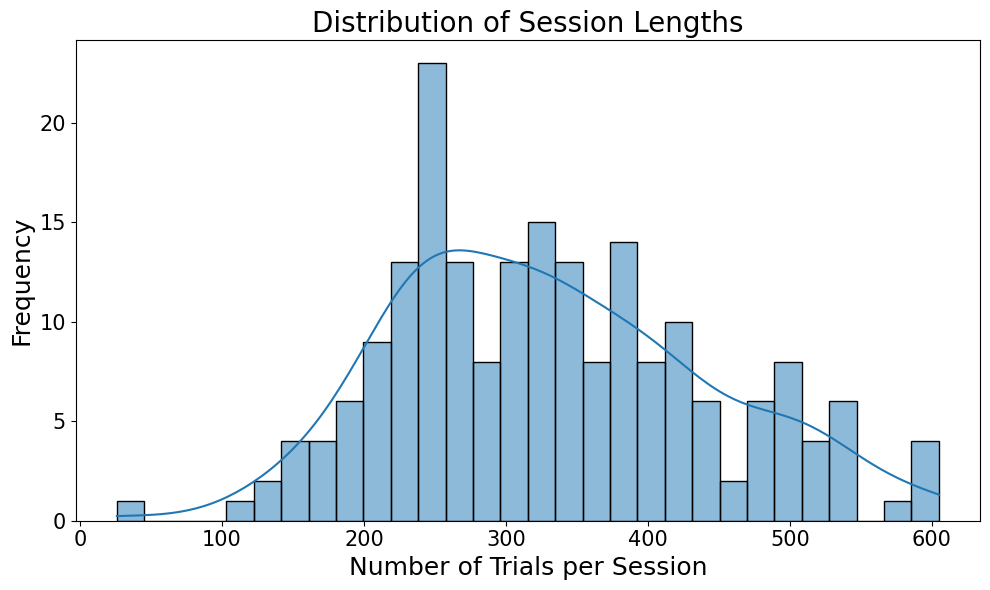

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 统计每个 session 的 trial 数量
session_lengths = mice_data.groupby(['subject','date']).size()

# 画出分布图
plt.figure(figsize=(10, 6))
sns.histplot(session_lengths, bins=30, kde=True)
plt.xlabel('Number of Trials per Session')
plt.ylabel('Frequency')
plt.title('Distribution of Session Lengths')
plt.grid(True)
plt.tight_layout()
plt.show()


### Human data Suthana 3-armed

In [10]:
!pwd

/teamspace/studios/this_studio/src


In [20]:
import gdown

# Google Drive 文件 ID（从你给的分享链接中提取）
file_id_human = '1ajVc9xNklThwXBD3q5s3hf2c9bIJcR-F'
# 构建直链 URL
url_human = f'https://drive.google.com/uc?id={file_id_human}'
# 指定本地保存文件名
output_human = 'human_data.csv'
# 下载文件（第一次会有进度条，后面会复用同名文件）
gdown.download(url_human, output_human, quiet=False)
# 用 pandas 读取
human_su_data = pd.read_csv(output_human)

# 为每个 (monkey, date, blockIndex) 内生成 trial_id，从0递增
human_su_data['trial_id'] = human_su_data.groupby(['subject']).cumcount()

# 创建 session key
human_su_data['session_key'] = human_su_data[['subject']].astype(str).agg('-'.join, axis=1)
# 编号 session，从1开始
human_su_data['session'] = human_su_data['session_key'].astype('category').cat.codes + 1
# 可选：删除临时变量
human_su_data = human_su_data.drop(columns='session_key')

#Generate dataset for training, validation
def generate_action_n(group):
    group['action_n'] = group['choice'].shift(-1)  # 将 action 列向上移动一行
    group['action_n'].iloc[-1] = -1  # 将每个组的最后一个值设为 -1
    return group

# 按 participant 分组并应用函数
human_su_data = human_su_data.groupby(['session']).apply(generate_action_n)
human_su_data = human_su_data.reset_index(drop=True)

# 确保 monkey_rnn 是按 session 和 trial_id 排好序的
human_su_rnn = human_su_data.sort_values(by=['session', 'trial_id'])

# 获取所有 session 的 id（已经筛选为 trial 数 >= 80）
session_ids = human_su_rnn['session'].unique()

# 初始化空列表
xs_list = []
ys_list = []

# 遍历每个 session
for session_id in session_ids:
    session_data = human_su_rnn[human_su_rnn['session'] == session_id]

    # 只保留前 80 个 trial（确保一致）
    session_data = session_data.iloc[:160]

    x = session_data[['choice', 'outcome']].to_numpy().astype(float)  # shape (80, 2)
    y = session_data[['action_n']].to_numpy().astype(int)            # shape (80, 1)

    xs_list.append(x)
    ys_list.append(y)

# 堆叠为 numpy array，并转置成 (80, 190, 2) 以及 (80, 190, 1)
xs = np.stack(xs_list, axis=0)  # shape (80, n_sessions, 2)
ys = np.stack(ys_list, axis=0)  # shape (80, n_sessions, 1)

Downloading...
From: https://drive.google.com/uc?id=1ajVc9xNklThwXBD3q5s3hf2c9bIJcR-F
To: /teamspace/studios/this_studio/src/human_data.csv
100%|██████████| 1.45M/1.45M [00:00<00:00, 158MB/s]


In [21]:
xs.shape

(808, 160, 2)

### Human data

In [12]:
# downlowd link for Google Drive
file_id = '1N_zAy-qrbfjvF8Kbb504IH2JNhR5KI-P'
download_url = f'https://drive.google.com/uc?id={file_id}'

# downlowd dataset as 'downloaded_file.csv'
output_file = 'downloaded_file.csv'
gdown.download(download_url, output_file, quiet=False)

# read data
eck_data = pd.read_csv(output_file)

selected_columns = ['sID', 'TrialID', 'selected_box', 'reward']

eck_sorted = eck_data[selected_columns]
eck_sorted['participant'] = eck_sorted.groupby(['sID']).ngroup() + 1
eck_sorted['action'] = eck_sorted['selected_box']

max_trial = eck_sorted.groupby('participant')['TrialID'].transform('max')
eck_sorted['max_trial'] = max_trial
eck_sorted = eck_sorted[eck_sorted['max_trial'] >= 120]

action_cols = ['action_{}'.format(i) for i in range(2)]  # this creates the following vector: 'action_0', 'action_1', 'action_2', 'action_3']
eck_sorted[action_cols] = jax.nn.one_hot(jnp.array(eck_sorted['action']), 2)
eck_sorted

# Number of participants (we are giving you the solution here already)
n_participants = len(np.unique(eck_sorted['participant']))

# Number of trials
# ============== FILL IN THE BLANKS BELOW ================
n_trials = len(np.unique(eck_sorted['TrialID']))

# Number of bandits
# ============== FILL IN THE BLANKS BELOW ================
n_bandits = len(np.unique(eck_sorted['action']))

# Min and max points
# ============== FILL IN THE BLANKS BELOW ================
min_points = 1#np.min(valetin['reward'])
max_points = 0#np.max(valetin['reward'])

# Print the results
print("Number of participants: {}".format(n_participants))
print("Number of trials per participant: {}".format(n_trials))
print("Number of bandits (available actions): {}".format(n_bandits))
print("Minimum number of points in this game: {}. Maximum number: {}".format(min_points, max_points))

def generate_action_n(group):
    group['action_n'] = group['action'].shift(-1)  # 将 action 列向上移动一行
    group['action_n'].iloc[-1] = -1  # 将每个组的最后一个值设为 -1
    return group

eck_sorted = eck_sorted[eck_sorted['TrialID'] <= 120]

# 重置索引（可选）
eck_sorted = eck_sorted.reset_index(drop=True)

# 按 participant 分组并应用函数
eck_sorted = eck_sorted.groupby('participant').apply(generate_action_n)

# 如果需要的话，可以重置索引
eck_sorted = eck_sorted.reset_index(drop=True)

eck_rnn = eck_sorted.sort_values(by=['TrialID', 'participant'])

# 提取action和reward列并转换为numpy数组
seq_rnn = eck_rnn[['action', 'reward','action_n']]

# 获取数据形状
n_sessions = 305
n_trials = 120

# 重塑数据为 (n_sessions, n_trials, 2)

xs = seq_rnn[['action','reward']].values.reshape(n_trials, n_sessions, 2).astype(float)

# 初始化ys并填充为-1
ys = seq_rnn[['action_n']].values.reshape(n_trials, n_sessions, 1).astype(int)

dataset_h1_train, dataset_h1_test, dataset_h1_validate = rat_data.format_into_datasets(xs,ys, rnn_utils.DatasetRNN,213, 46, 46)

Downloading...
From: https://drive.google.com/uc?id=1N_zAy-qrbfjvF8Kbb504IH2JNhR5KI-P
To: /teamspace/studios/this_studio/src/downloaded_file.csv
100%|██████████| 2.57M/2.57M [00:00<00:00, 205MB/s]


Number of participants: 305
Number of trials per participant: 156
Number of bandits (available actions): 2
Minimum number of points in this game: 1. Maximum number: 0


### Functions for computing log likelihood

In [18]:
import numpy as np

#@title Compute log-likelihood
def compute_log_likelihood(dataset, model_fun, params):
    xs, actual_choices = next(dataset)
    n_trials_per_session, n_sessions = actual_choices.shape[:2]
    model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

    predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

    log_likelihoods = []

    for sess_i in range(n_sessions):
        log_likelihood = 0
        n = 0  # Total number of trials for this session.
        for trial_i in range(n_trials_per_session):
            actual_choice = int(actual_choices[trial_i, sess_i])
            if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
                log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
                n += 1

        # Calculate normalized likelihood for this session
        if n > 0:
            normalized_likelihood = np.exp(log_likelihood / n)
            log_likelihoods.append(normalized_likelihood)

    # Compute mean and standard deviation across all sessions
    mean_likelihood = np.mean(log_likelihoods)
    std_likelihood = np.std(log_likelihoods)

    print(f'Average Normalized Likelihood: {100 * mean_likelihood:.1f}%')
    #print(f'Standard Deviation of Likelihood: {100 * std_likelihood:.1f}%')

    return mean_likelihood, std_likelihood

In [19]:
import numpy as np

# @title Compute average negative log-likelihood (NLL)
def compute_negative_log_likelihood(dataset, model_fun, params):
    xs, actual_choices = next(dataset)
    n_trials_per_session, n_sessions = actual_choices.shape[:2]
    model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

    # Get log-softmax of the first two outputs (assumed to be choice probabilities)
    predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

    total_log_likelihood = 0.0
    total_valid_trials = 0

    for sess_i in range(n_sessions):
        for trial_i in range(n_trials_per_session):
            actual_choice = int(actual_choices[trial_i, sess_i])
            if actual_choice >= 0:  # Skip invalid trials
                total_log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
                total_valid_trials += 1

    if total_valid_trials == 0:
        raise ValueError("No valid trials found.")

    # Average negative log-likelihood (NLL)
    avg_nll = -total_log_likelihood / total_valid_trials

    print(f'Average Negative Log-Likelihood: {avg_nll:.4f}')

    return avg_nll


### Functions for organizing monkey data

In [9]:
def format_into_datasets_multi_monkey(
    xs_list: list[np.ndarray],
    ys_list: list[np.ndarray],
    dataset_constructor,
    n_train_sessions: int,
    n_test_sessions: int,
    n_validate_sessions: int,
    batch_size: int = None,
    random_seed: int = None,
):
    """
    把多只猴子的 (xs, ys) 按 session 数比例，划分为全局 train/test/validate。

    Args:
      xs_list, ys_list: 每只猴子的数组，shape=(timesteps, n_sessions_i, feat)
      dataset_constructor: DatasetRNN 或其他同接口构造器
      n_train_sessions:    全体一共要选多少 session 做训练
      n_test_sessions:     全体要选多少 session 做测试
      n_validate_sessions: 全体要选多少 session 做验证
      batch_size:          传给 DatasetRNN 的 batch_size
      random_seed:         np.random.RandomState 用于可复现

    Returns:
      ds_train, ds_test, ds_val: 三个 DatasetRNN，里面包含来自三只猴子的 session
    """
    # 1. 计算每只猴子 session 数
    n_monkeys = len(xs_list)
    sess_counts = np.array([xs.shape[1] for xs in xs_list])       # [s1, s2, s3]
    total_sess  = sess_counts.sum()

    # 2. 按比例分配到每只猴子的各集合
    def _proportional_alloc(total, counts):
        # 先浮点分配
        floats = counts / counts.sum() * total
        floors = np.floor(floats).astype(int)
        rem = total - floors.sum()
        # 按余数大小补齐
        remainders = floats - floors
        for idx in np.argsort(remainders)[-rem:]:
            floors[idx] += 1
        return floors

    n_train_per_monkey = _proportional_alloc(n_train_sessions, sess_counts)
    n_test_per_monkey  = _proportional_alloc(n_test_sessions,  sess_counts)
    n_val_per_monkey   = _proportional_alloc(n_validate_sessions, sess_counts)

    if random_seed is not None:
        rng = np.random.RandomState(random_seed)
    else:
        rng = np.random

    # 3. 对每只猴子分别抽 idx
    train_slices, test_slices, val_slices = [], [], []
    for i in range(n_monkeys):
        n_sess = sess_counts[i]
        all_idx = np.arange(n_sess)
        rng.shuffle(all_idx)
        start = 0
        train_idx = all_idx[start:start + n_train_per_monkey[i]]
        start += n_train_per_monkey[i]
        test_idx  = all_idx[start:start + n_test_per_monkey[i]]
        start += n_test_per_monkey[i]
        val_idx   = all_idx[start:start + n_val_per_monkey[i]]
        train_slices.append(train_idx)
        test_slices.append(test_idx)
        val_slices.append(val_idx)

    # 4. 汇总三只猴子的训练 / 测试 / 验证数据
    def _gather(xs_list, ys_list, idx_slices):
        # 把每只猴子的选中 sessions 按时间步拼到一起
        parts_x, parts_y = [], []
        for xs, ys, idx in zip(xs_list, ys_list, idx_slices):
            # xs: (timesteps, n_sess_i, feat)
            parts_x.append(xs[:, idx, :])
            parts_y.append(ys[:, idx, :])
        # concat 的结果 shape=(timesteps, sum(n_i), feat)
        return np.concatenate(parts_x, axis=1), np.concatenate(parts_y, axis=1)

    xs_train, ys_train = _gather(xs_list, ys_list, train_slices)
    xs_test,  ys_test  = _gather(xs_list, ys_list, test_slices)
    xs_val,   ys_val   = _gather(xs_list, ys_list, val_slices)

    # 5. 构造 DatasetRNN
    ds_train = dataset_constructor(xs_train, ys_train, batch_size=batch_size)
    ds_test  = dataset_constructor(xs_test,  ys_test,  batch_size=batch_size)
    ds_val   = dataset_constructor(xs_val,   ys_val,   batch_size=batch_size)

    return ds_train, ds_test, ds_val


In [10]:
def format_into_datasets_10_multi(
    xs_list: list[np.ndarray],
    ys_list: list[np.ndarray],
    dataset_constructor,
    batch_size: int = None,
    random_seed: int = None,
):
    """
    对多只猴子独立做 10‐fold CV，每折：
      - test = 每只猴子第 i 份 fold
      - validation 抽取与 test 大小一致的 session
      - 剩余做 train
    Args:
      xs_list: list of np.ndarray, 每项形状 (timesteps, n_sess_i, feat)
      ys_list: list of np.ndarray, 每项形状 (timesteps, n_sess_i, ...)
      dataset_constructor: 接受 (xs_sub, ys_sub, batch_size) 的构造器
      batch_size: mini‐batch 大小；None 则每 dataset 用全部 episodes
      random_seed: int，可复现打乱
    Returns:
      List of 10 tuples (ds_train, ds_val, ds_test)
    """
    rng = np.random.RandomState(random_seed) if random_seed is not None else np.random

    n_monkeys = len(xs_list)
    # 1. 对每只猴子生成打乱后的 session 索引，并切成 10 份
    folds_per_monkey = []
    for xs in xs_list:
        n_sess = xs.shape[1]
        idx = rng.permutation(n_sess)
        folds = np.array_split(idx, 10)
        folds_per_monkey.append(folds)

    folds_datasets = []
    for i in range(10):
        # 2a. 测试集：三猴子各自的第 i 份
        test_parts = [folds_per_monkey[m][i] for m in range(n_monkeys)]

        # 2b. 剩余 sessions 用于 train+val
        rem_parts = [
            np.hstack([folds_per_monkey[m][j] for j in range(10) if j != i])
            for m in range(n_monkeys)
        ]

        # 2c. 验证集大小与测试集一致：每只猴子抽取与 test_parts[m] 相同数量
        val_parts = []
        train_parts = []
        for m in range(n_monkeys):
            rng.shuffle(rem_parts[m])
            n_test = len(test_parts[m])
            val = rem_parts[m][:n_test]
            train = rem_parts[m][n_test:]
            val_parts.append(val)
            train_parts.append(train)

        # 3. 拼接各猴子的 train/val/test xs, ys
        def _gather(parts_idx):
            xs_sub, ys_sub = [], []
            for m, idxs in enumerate(parts_idx):
                xs_sub.append(xs_list[m][:, idxs, :])
                ys_sub.append(ys_list[m][:, idxs, :])
            return np.concatenate(xs_sub, axis=1), np.concatenate(ys_sub, axis=1)

        xs_train, ys_train = _gather(train_parts)
        xs_val,   ys_val   = _gather(val_parts)
        xs_test,  ys_test  = _gather(test_parts)

        # 4. 构造 DatasetRNN
        ds_train = dataset_constructor(xs_train, ys_train, batch_size=batch_size)
        ds_val   = dataset_constructor(xs_val,   ys_val,   batch_size=batch_size)
        ds_test  = dataset_constructor(xs_test,  ys_test,  batch_size=batch_size)

        folds_datasets.append((ds_train, ds_val, ds_test))

    return folds_datasets


In [11]:
# from google.colab import drive
# import pickle

# # 挂载 Google Drive
# drive.mount('/content/drive')

# Fitting different models

## Organize monkey data

In [15]:
# 这是为了把上面猴子的数据给合并，然后调用我的这个format_into_datasets，生成三个数据集
# 假设你已经有三个 np.ndarray：xs1,ys1；xs2,ys2；xs3,ys3
xs_list = [xs_V, xs_w, xs_i]
ys_list = [ys_V, ys_w, ys_i]

folds_datasets = format_into_datasets_10_multi(
    xs_list, ys_list,
    dataset_constructor=rnn_utils.DatasetRNN,
    batch_size=64,
    random_seed=42
)


In [16]:
# folds = rat_data.format_into_datasets_10(
#     xs_m, ys_m,
#     dataset_constructor=rnn_utils.DatasetRNN,
#     n_validate_sessions=36,
#     random_seed=123
# )

for i, (train_ds, val_ds, test_ds) in enumerate(folds_datasets):
    print(f"Fold {i}: "
          f"train episodes={train_ds._dataset_size}, "
          f"val episodes={val_ds._dataset_size}, "
          f"test episodes={test_ds._dataset_size}")
    # 在这里用 train_ds/val_ds 选超参，最后在 test_ds 上跑一次评估


Fold 0: train episodes=320, val episodes=64, test episodes=64
Fold 1: train episodes=320, val episodes=64, test episodes=64
Fold 2: train episodes=320, val episodes=64, test episodes=64
Fold 3: train episodes=320, val episodes=64, test episodes=64
Fold 4: train episodes=320, val episodes=64, test episodes=64
Fold 5: train episodes=320, val episodes=64, test episodes=64
Fold 6: train episodes=320, val episodes=64, test episodes=64
Fold 7: train episodes=320, val episodes=64, test episodes=64
Fold 8: train episodes=320, val episodes=64, test episodes=64
Fold 9: train episodes=320, val episodes=64, test episodes=64


## Fit RL

In [19]:
# 这个就是最简单的Rescolar模型的运行代码，你主要移植的就是这个AgentQ
rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset_train = dataset_m_train,
    dataset_test = dataset_m_validate,
    loss_fun='categorical',
    optimizer= optax.chain(
        optax.add_decayed_weights(1e-5),  # L2 正则化
        optax.adam(learning_rate=1e-4)  # Adam 优化器
    ),
    n_steps_per_call=500,
    n_steps_max=100000,
    #return_all_losses=True,
    early_stop_step=200)

NameError: name 'dataset_m_train' is not defined

In [ ]:
mean_likelihood, std_likelihood = compute_log_likelihood(dataset_m_test, bandits.HkAgentQ, rl_params)
mean_nll = compute_negative_log_likelihood(dataset_m_test, bandits.HkAgentQ, rl_params)

Average Normalized Likelihood: 73.5%
Average Negative Log-Likelihood: 0.3849


In [ ]:
# 这个相当于是最好的认知模型，在rescolar里面加了一些参数
rl_pc_params, _ = rnn_utils.fit_model(
    model_fun=bandits.Hk_PreserveConAgentQ,
    dataset_train = dataset_m_train,
    dataset_test = dataset_m_validate,
    loss_fun='categorical',
    optimizer= optax.chain(
        optax.add_decayed_weights(1e-5),  # L2 正则化
        optax.adam(learning_rate=1e-4)  # Adam 优化器
    ),
    n_steps_per_call=200,
    n_steps_max=100000,
    #return_all_losses=True,
    early_stop_step=200)

Step 200 of 200; Loss: 4.7465e+02; Test Loss: 4.7362e+02. (Time: 2.8s)Step 200 of 100000; Loss: 3.9309e+02. (Time: 0.0s)
Step 200 of 200; Loss: 5.6175e+02; Test Loss: 4.6769e+02. (Time: 2.3s)Step 400 of 100000; Loss: 3.8751e+02. (Time: 0.0s)
Step 200 of 200; Loss: 4.9391e+02; Test Loss: 4.6197e+02. (Time: 2.3s)Step 600 of 100000; Loss: 3.8214e+02. (Time: 0.0s)
Step 200 of 200; Loss: 4.4997e+02; Test Loss: 4.5646e+02. (Time: 2.5s)Step 800 of 100000; Loss: 3.7696e+02. (Time: 0.0s)
Step 200 of 200; Loss: 4.1765e+02; Test Loss: 4.5113e+02. (Time: 3.5s)Step 1000 of 100000; Loss: 3.7197e+02. (Time: 0.0s)
Step 200 of 200; Loss: 5.2467e+02; Test Loss: 4.4598e+02. (Time: 2.3s)Step 1200 of 100000; Loss: 3.6714e+02. (Time: 0.0s)
Step 200 of 200; Loss: 3.3369e+02; Test Loss: 4.4101e+02. (Time: 2.5s)Step 1400 of 100000; Loss: 3.6248e+02. (Time: 0.0s)
Step 200 of 200; Loss: 5.2351e+02; Test Loss: 4.3620e+02. (Time: 2.4s)Step 1600 of 100000; Loss: 3.5798e+02. (Time: 0.0s)
Step 200 of 200; Loss: 4.852

In [ ]:
mean_likelihood, std_likelihood = compute_log_likelihood(dataset_m_test, bandits.Hk_PreserveConAgentQ, rl_pc_params)
mean_nll = compute_negative_log_likelihood(dataset_m_test, bandits.Hk_PreserveConAgentQ, rl_pc_params)

Average Normalized Likelihood: 73.4%
Average Negative Log-Likelihood: 0.3985


In [ ]:
xs_list = [xs_V, xs_w, xs_i]
ys_list = [ys_V, ys_w, ys_i]

folds = format_into_datasets_10_multi(
    xs_list, ys_list,
    dataset_constructor=rnn_utils.DatasetRNN,
    batch_size=64,
    random_seed=42
)

n_folds = len(folds)
avg_nlls = np.zeros(n_folds)

for i, (train_ds, val_ds, test_ds) in enumerate(folds):
    print(f"=== Fold {i} ===")
    # 用 train/val 训练并选超参
    params, _ = rnn_utils.fit_model(
        model_fun=bandits.Hk_PreserveConAgentQ,
        dataset_train=train_ds,
        dataset_test=val_ds,      # 用 val_ds 做 early-stop
        optimizer=optax.chain(
            optax.add_decayed_weights(1e-5),
            optax.adam(learning_rate=1e-3)
        ),
        n_steps_per_call=500,
        n_steps_max=1000000,
        early_stop_step=200,
    )

    # 在 test_ds 上计算平均 NLL
    avg_nll = compute_negative_log_likelihood(test_ds, bandits.Hk_PreserveConAgentQ, params)
    print(f"Fold {i} test Avg NLL: {avg_nll:.4f}\n")
    avg_nlls[i] = avg_nll

# 汇总
mean_nll = avg_nlls.mean()
std_nll  = avg_nlls.std(ddof=1)    # 样本标准差
se_nll   = std_nll / np.sqrt(n_folds)

print("All folds Avg NLL:", avg_nlls)
print(f"Mean NLL over folds: {mean_nll:.4f}")
print(f"Stddev over folds : {std_nll:.4f}")
print(f"Std. Error (SE)    : {se_nll:.4f}")


Fold 0:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 1:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 2:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 3:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 4:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=117, val=15, test=15
Fold 5:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=117, val=15, test=15
Fold 6:
  Monkey 0: train=78, val=9, test=9
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=117, val=15, test=15
Fold 7:
  Monkey 0: train=78, val=9, test=9
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=119, val=14, test=14
Fold 8:
  Monkey 0: train=78

## Fit Vanilla RNN

### For Monkey

#### Find #steps for each learning rate

Step 200 of 200; Loss: 3.0400e+03; Test Loss: 1.0495e+03. (Time: 2.2s)updating best model ..
Step 200 of 5000; Loss: 1.0738e+03. (Time: 0.0s)
Step 200 of 200; Loss: 8.4095e+02; Test Loss: 7.9454e+02. (Time: 2.6s)updating best model ..
Step 400 of 5000; Loss: 8.1270e+02. (Time: 0.0s)
Step 200 of 200; Loss: 6.3733e+01; Test Loss: 7.6827e+02. (Time: 2.2s)updating best model ..
Step 600 of 5000; Loss: 7.6995e+02. (Time: 0.0s)
Step 200 of 200; Loss: 5.3733e+00; Test Loss: 7.5969e+02. (Time: 2.7s)updating best model ..
Step 800 of 5000; Loss: 7.6003e+02. (Time: 0.0s)
Step 200 of 200; Loss: 1.9361e+03; Test Loss: 7.5879e+02. (Time: 2.3s)updating best model ..
Step 1000 of 5000; Loss: 7.5896e+02. (Time: 0.0s)
Step 200 of 200; Loss: 2.2553e+03; Test Loss: 7.5941e+02. (Time: 2.2s)Step 1200 of 5000; Loss: 7.5922e+02. (Time: 0.0s)
Step 200 of 200; Loss: 7.1093e+02; Test Loss: 7.5893e+02. (Time: 2.2s)Step 1400 of 5000; Loss: 7.5899e+02. (Time: 0.0s)
Step 200 of 200; Loss: 3.1794e+01; Test Loss: 7.5

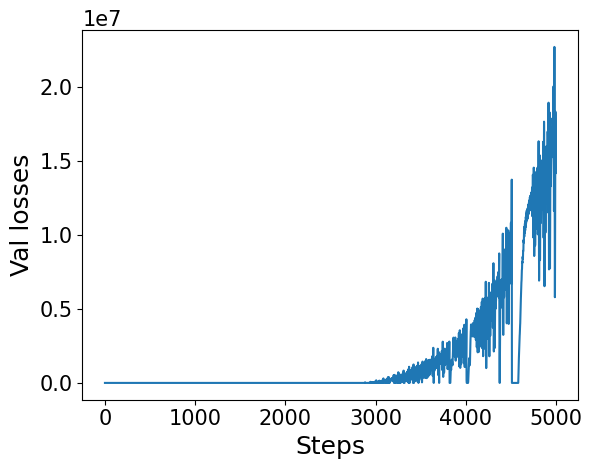

In [21]:
dataset_m_train, dataset_m_test, dataset_m_validate = format_into_datasets_multi_monkey(
    xs_list, ys_list,
    dataset_constructor=rnn_utils.DatasetRNN,
    n_train_sessions=267,    # 全体一共要选 200 个 session 做训练
    n_test_sessions= 35,     # 全体 40 做测试
    n_validate_sessions=35,  # 全体 40 做验证
    batch_size=64,
    random_seed=42
)
n_hidden = 64
def make_vanilla_rnn():
    model = hk.DeepRNN(
        [hk.VanillaRNN(n_hidden), hk.Linear(output_size=2)]
    )
    return model

# Fit the model
vanillaRNN_params, _, all_losses = rnn_utils.fit_model(
    model_fun=make_vanilla_rnn,
    dataset_train=dataset_m_train,
    dataset_test=dataset_m_validate,
    loss_fun='categorical',
    optimizer=optax.chain(
        optax.add_decayed_weights(1e-4),  # L2 regularization
        optax.adam(learning_rate=1e-4)    # Adam optimizer
    ),
    n_steps_per_call=200,
    n_steps_max=5000,
    return_all_losses=True,
    early_stop_step=200
)

# Extract validation losses (assuming all_losses is a dict with 'test' key)
avg_nll = compute_negative_log_likelihood(dataset_m_validate, make_vanilla_rnn, vanillaRNN_params)
plt.plot(all_losses)
plt.xlabel('Steps')
plt.ylabel('Val losses')
plt.show()

In [ ]:
# run for 5 times, see how results differ --> 都一样
avg_nlls = [0.3597, 0.3597, 0.3597]

#### This is for hyperparameter search of Vanilla RNN on Monkey


In [ ]:
import itertools
import os
import pandas as pd
import time

# Define hyperparameter grid
param_grid = {
    'hidden_size': [2, 4, 8, 16, 32, 64],
    'lr': [1e-3, 1e-4],
    'weight_decay': [1e-3, 1e-4, 1e-5],
    'batch_size': [32, 64],
}

# Prepare to collect results
output_path = '../Results/monkey_grid_search_results.csv'
# 如果文件不存在，就写入 header；否则 append 时不写 header
write_header = not os.path.exists(output_path)

# Loop through all combinations
for hs, lr, wd, bs in itertools.product(
        param_grid['hidden_size'],
        param_grid['lr'],
        param_grid['weight_decay'],
        param_grid['batch_size'],
):
    print(f"Running configuration: hidden_size={hs}, lr={lr}, weight_decay={wd}, batch_size={bs}")
    dataset_m_train, dataset_m_test, dataset_m_validate = format_into_datasets_multi_monkey(
        xs_list, ys_list,
        dataset_constructor=rnn_utils.DatasetRNN,
        n_train_sessions=267,    # 全体一共要选 200 个 session 做训练
        n_test_sessions= 35,     # 全体 40 做测试
        n_validate_sessions=35,  # 全体 40 做验证
        batch_size=bs,
        random_seed=42
    )
    n_hidden = hs
    def make_vanilla_rnn():
        model = hk.DeepRNN(
            [hk.VanillaRNN(n_hidden), hk.Linear(output_size=2)]
        )
        return model

    # # set n_step_max for each lr
    # if lr == 1e-3:
    #     n_step_max = 10000
    # elif lr == 1e-4:
    #     n_step_max = 30000

    # Fit the model    
    t0 = time.time()
    vanillaRNN_params, _, all_losses = rnn_utils.fit_model(
        model_fun=make_vanilla_rnn,
        dataset_train=dataset_m_train,
        dataset_test=dataset_m_validate,
        loss_fun='categorical',
        optimizer=optax.chain(
            optax.add_decayed_weights(wd),  # L2 regularization
            optax.adam(learning_rate=lr)    # Adam optimizer
        ),
        n_steps_per_call=200,
        n_steps_max=100000,
        return_all_losses=True,
        early_stop_step=400,
        if_early_stop=True
    )

    # Extract validation losses (assuming all_losses is a dict with 'test' key)
    avg_nll = compute_negative_log_likelihood(dataset_m_validate, make_vanilla_rnn, vanillaRNN_params)

    # Record the result
    result = {
        'hidden_size': hs,
        'lr': lr,
        'weight_decay': wd,
        'batch_size': bs,
        'avg_val_nll': avg_nll,
        'time': time.time()-t0,
    }

    pd.DataFrame([result]).to_csv(
        output_path,
        mode='a',            # 追加而非覆盖
        index=False,
        header=write_header  # 只有第一次写入 header
    )
    write_header = False   # header 只写一次

Running configuration: hidden_size=4, lr=0.001, weight_decay=0.001, batch_size=32
Step 200 of 200; Loss: 1.5939e+03; Test Loss: 4.6920e+01. (Time: 2.1s)Step 200 of 1000000; Loss: 6.8287e+02. (Time: 0.0s)
Step 200 of 200; Loss: 6.3335e+02; Test Loss: 3.7367e+01. (Time: 2.2s)Step 400 of 1000000; Loss: 6.2188e+02. (Time: 0.0s)
Step 200 of 200; Loss: 1.1664e+03; Test Loss: 3.9299e+00. (Time: 7.0s)Step 600 of 1000000; Loss: 4.4289e+02. (Time: 0.0s)
Step 200 of 200; Loss: 1.3098e+03; Test Loss: 3.5063e+00. (Time: 2.7s)Step 800 of 1000000; Loss: 4.3315e+02. (Time: 0.0s)
Step 200 of 200; Loss: 8.9149e+01; Test Loss: 3.1404e+00. (Time: 2.2s)Step 1000 of 1000000; Loss: 4.2756e+02. (Time: 0.0s)
Step 200 of 200; Loss: 1.0793e+03; Test Loss: 2.8327e+00. (Time: 2.3s)Step 1200 of 1000000; Loss: 4.2333e+02. (Time: 0.0s)
Step 200 of 200; Loss: 1.2614e+03; Test Loss: 2.5768e+00. (Time: 2.5s)Step 1400 of 1000000; Loss: 4.2046e+02. (Time: 0.0s)
Step 200 of 200; Loss: 5.7415e+01; Test Loss: 2.3577e+00. (Ti

In [ ]:
df = pd.read_csv('../Results/monkey_grid_search_results.csv')

# 打印完整的 DataFrame
print(df)

In [ ]:
# select the best hyperparams
# 1. 找到 'avg_val_nll' 最小值所在的行索引
best_idx = df['avg_val_nll'].idxmin()
# 2. 取出该行
best_row = df.loc[best_idx]
# 3. 如果你只想要超参（不包括 avg_val_nll 本身），可以这样：
best_params = best_row[['hidden_size', 'lr', 'weight_decay', 'batch_size']].to_dict()
print("最优参数：", best_params)
print("对应最小 avg_val_nll:", best_row['avg_val_nll'])

#### Now for outer loop

In [ ]:
## Generate outerloop datasets
# 这是为了把上面猴子的数据给合并，然后调用我的这个format_into_datasets，生成三个数据集
# 假设你已经有三个 np.ndarray：xs1,ys1；xs2,ys2；xs3,ys3
xs_list = [xs_V, xs_w, xs_i]
ys_list = [ys_V, ys_w, ys_i]

folds = format_into_datasets_10_multi(
    xs_list, ys_list,
    dataset_constructor=rnn_utils.DatasetRNN,
    batch_size=best_params['batch_size'],
    random_seed=42
)

Fold 0:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 1:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 2:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 3:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=74, val=10, test=10
  Monkey 2: train=117, val=15, test=15
Fold 4:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=117, val=15, test=15
Fold 5:
  Monkey 0: train=76, val=10, test=10
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=117, val=15, test=15
Fold 6:
  Monkey 0: train=78, val=9, test=9
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=117, val=15, test=15
Fold 7:
  Monkey 0: train=78, val=9, test=9
  Monkey 1: train=76, val=9, test=9
  Monkey 2: train=119, val=14, test=14
Fold 8:
  Monkey 0: train=78

In [ ]:
## Define the best Vanilla RNN with 32 units
n_hidden = best_params['hidden_size']
def make_vanilla_rnn():
    model = hk.DeepRNN(
        [hk.VanillaRNN(n_hidden), hk.Linear(output_size=2)]
    )
    return model

n_folds = len(folds)
avg_nlls = np.zeros(n_folds)
best_models = []

if best_params['lr'] == 1e-3:
    n_step_max = 10000
elif best_params['lr'] == 1e-4:
    n_step_max = 30000

for i, (train_ds, val_ds, test_ds) in enumerate(folds):
    print(f"=== Fold {i} ===")
    # 用 train/val 训练并选超参
    params, _ = rnn_utils.fit_model(
        model_fun=make_vanilla_rnn,
        dataset_train=train_ds,
        dataset_test=val_ds,      # 用 val_ds 做 early-stop
        optimizer=optax.chain(
            optax.add_decayed_weights(best_params['weight_decay']),
            optax.adam(learning_rate=best_params['lr'])
        ),
        n_steps_per_call=200,
        n_steps_max=n_step_max,
        # early_stop_step=200,
    )

    best_models.append(params)

    # 在 test_ds 上计算平均 NLL
    avg_nll = compute_negative_log_likelihood(test_ds, make_vanilla_rnn, params)
    print(f"Fold {i} test Avg NLL: {avg_nll:.4f}\n")
    avg_nlls[i] = avg_nll

# 汇总
mean_nll = avg_nlls.mean()
std_nll  = avg_nlls.std(ddof=1)    # 样本标准差
se_nll   = std_nll / np.sqrt(n_folds)

print("All folds Avg NLL:", avg_nlls)
print(f"Mean NLL over folds: {mean_nll:.4f}")
print(f"Stddev over folds : {std_nll:.4f}")
print(f"Std. Error (SE)    : {se_nll:.4f}")

# save the results
import pickle
best_dict = {'best_params': best_params, 'best_models': best_models, 'NLLs': avg_nlls}
with open('../Results/monkey_best_res.pkl', 'wb') as f:
    pickle.dump(best_dict, f)

In [ ]:
#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_m_train, make_vanilla_rnn, gru_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_m_test, make_vanilla_rnn, gru_params)

Normalized Likelihoods for GRU
Training Dataset
Average Normalized Likelihood: 81.1%
Held-Out Dataset
Average Normalized Likelihood: 84.1%


In [ ]:
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_m_test, make_vanilla_rnn, gru_params)
testing_likelihood = compute_negative_log_likelihood(dataset_m_test, make_vanilla_rnn, gru_params)

Held-Out Dataset
Average Normalized Likelihood: 84.1%
Average Negative Log-Likelihood: 0.2636


### For Mice

#### grid search

In [1]:
import itertools
import os
import pandas as pd
import time
# Define hyperparameter grid
param_grid = {
    'hidden_size': [2, 64], 
    'lr': [1e-3, 1e-4],
    'weight_decay': [1e-3, 1e-4, 1e-5],
    'batch_size': [32, 64],
}

# Prepare to collect results
output_path = '../Results/mice_grid_search_results.csv'
# 1. 读取已存在的结果
if os.path.exists(output_path):
    df_existing = pd.read_csv(output_path)
else:
    # 定义空的 DataFrame，并确保列对齐
    df_existing = pd.DataFrame(columns=[
        'hidden_size', 'lr', 'weight_decay', 'batch_size', 'avg_val_nll', 'time'
    ])
# 2. 是否第一次写 header
write_header = not os.path.exists(output_path)

# Loop through all combinations
for hs, lr, wd, bs in itertools.product(
        param_grid['hidden_size'],
        param_grid['lr'],
        param_grid['weight_decay'],
        param_grid['batch_size'],
):
    # 跳过已完成的配置
    mask = (
        (df_existing['hidden_size'] == hs) &
        (df_existing['lr'] == lr) &
        (df_existing['weight_decay'] == wd) &
        (df_existing['batch_size'] == bs)
    )
    if mask.any():
        print(f"Skipping existing configuration: hidden_size={hs}, lr={lr}, "
              f"weight_decay={wd}, batch_size={bs}")
        continue

    print(f"Running configuration: hidden_size={hs}, lr={lr}, weight_decay={wd}, batch_size={bs}")
    dataset_r_train, dataset_r_test, dataset_r_validate = rat_data.format_into_datasets(xs_array,ys_array, rnn_utils.DatasetRNN,438, 55, 55,
                                                                                           bs, 42)
    n_hidden = hs
    def make_vanilla_rnn():
        model = hk.DeepRNN(
            [hk.VanillaRNN(n_hidden), hk.Linear(output_size=2)]
        )
        return model
    
    # # set n_step_max for each lr
    # if lr == 1e-3:
    #     n_step_max = 15000
    # elif lr == 1e-4:
    #     n_step_max = 50000

    # Fit the model
    t0 = time.time()
    vanillaRNN_params, _, all_losses = rnn_utils.fit_model(
        model_fun=make_vanilla_rnn,
        dataset_train=dataset_r_train,
        dataset_test=dataset_r_validate,
        loss_fun='categorical',
        optimizer=optax.chain(
            optax.add_decayed_weights(wd),  # L2 regularization
            optax.adam(learning_rate=lr)    # Adam optimizer
        ),
        n_steps_per_call=200,
        n_steps_max=100000,
        return_all_losses=True,
        early_stop_step=400,
        if_early_stop=True
    )

    # Extract validation losses (assuming all_losses is a dict with 'test' key)
    avg_nll = compute_negative_log_likelihood(dataset_r_validate, make_vanilla_rnn, vanillaRNN_params)

    # Record the result
    result = {
        'hidden_size': hs,
        'lr': lr,
        'weight_decay': wd,
        'batch_size': bs,
        'avg_val_nll': avg_nll,
        'time': time.time() - t0
    }

    # 保存当次结果到 CSV
    pd.DataFrame([result]).to_csv(
        output_path,
        mode='a',            # 追加而非覆盖
        index=False,
        header=write_header  # 只有第一次写入 header
    )
    write_header = False   # header 只写一次

    print(f"Saved result for hs={hs}, lr={lr}, wd={wd}, bs={bs}, used time {result['time']}")


Skipping existing configuration: hidden_size=2, lr=0.001, weight_decay=0.001, batch_size=32
Skipping existing configuration: hidden_size=2, lr=0.001, weight_decay=0.001, batch_size=64
Skipping existing configuration: hidden_size=2, lr=0.001, weight_decay=0.0001, batch_size=32
Skipping existing configuration: hidden_size=2, lr=0.001, weight_decay=0.0001, batch_size=64
Skipping existing configuration: hidden_size=2, lr=0.001, weight_decay=1e-05, batch_size=32
Skipping existing configuration: hidden_size=2, lr=0.001, weight_decay=1e-05, batch_size=64
Skipping existing configuration: hidden_size=2, lr=0.0001, weight_decay=0.001, batch_size=32
Skipping existing configuration: hidden_size=2, lr=0.0001, weight_decay=0.001, batch_size=64
Skipping existing configuration: hidden_size=2, lr=0.0001, weight_decay=0.0001, batch_size=32
Skipping existing configuration: hidden_size=2, lr=0.0001, weight_decay=0.0001, batch_size=64
Skipping existing configuration: hidden_size=2, lr=0.0001, weight_decay=

In [2]:
df = pd.read_csv('../Results/mice_grid_search_results.csv')

# 打印完整的 DataFrame
print(df)

    hidden_size      lr  weight_decay  batch_size  avg_val_nll        time
0             4  0.0010       0.00100          32     0.363457  388.695748
1             4  0.0010       0.00100          64     0.387707  339.140196
2             4  0.0010       0.00010          32     0.363530  394.618540
3             4  0.0010       0.00010          64     0.387695  353.918199
4             4  0.0010       0.00001          32     0.363463  395.954787
..          ...     ...           ...         ...          ...         ...
67           64  0.0001       0.00100          64     0.381583  123.226999
68           64  0.0001       0.00010          32     0.357463  141.919497
69           64  0.0001       0.00010          64     0.381908  120.329490
70           64  0.0001       0.00001          32     0.358942  120.453786
71           64  0.0001       0.00001          64     0.381636  119.434480

[72 rows x 6 columns]


In [3]:
# select the best hyperparams
# 1. 找到 'avg_val_nll' 最小值所在的行索引
best_idx = df['avg_val_nll'].idxmin()
# 2. 取出该行
best_row = df.loc[best_idx]
# 3. 如果你只想要超参（不包括 avg_val_nll 本身），可以这样：
best_params = best_row[['hidden_size', 'lr', 'weight_decay', 'batch_size']].to_dict()
print("最优参数：", best_params)
print("对应最小 avg_val_nll:", best_row['avg_val_nll'])

最优参数： {'hidden_size': 64.0, 'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 32.0}
对应最小 avg_val_nll: 0.3574631807033438


#### Outer loop

In [16]:
## Generate outerloop datasets
# 这是为了把上面猴子的数据给合并，然后调用我的这个format_into_datasets，生成三个数据集
# 假设你已经有三个 np.ndarray：xs1,ys1；xs2,ys2；xs3,ys3

folds = rat_data.format_into_datasets_10(
    xs_array, ys_array,
    dataset_constructor=rnn_utils.DatasetRNN,
    n_validate_sessions=55,
    batch_size=int(best_params['batch_size']),
    random_seed=42
)

In [20]:
## Define the best Vanilla RNN with 32 units
n_hidden = int(best_params['hidden_size'])
def make_vanilla_rnn():
    model = hk.DeepRNN(
        [hk.VanillaRNN(n_hidden), hk.Linear(output_size=2)]
    )
    return model

n_folds = len(folds)
avg_nlls = np.zeros(n_folds)
best_models = []

# # set n_step_max for each lr
# if best_params['lr'] == 1e-3:
#     n_step_max = 15000
# elif best_params['lr'] == 1e-4:
#     n_step_max = 50000

for i, (train_ds, val_ds, test_ds) in enumerate(folds):
    print(f"=== Fold {i} ===")
    # 用 train/val 训练并选超参
    params, _ = rnn_utils.fit_model(
        model_fun=make_vanilla_rnn,
        dataset_train=train_ds,
        dataset_test=val_ds,      # 用 val_ds 做 early-stop
        optimizer=optax.chain(
            optax.add_decayed_weights(best_params['weight_decay']),
            optax.adam(learning_rate=best_params['lr'])
        ),
        n_steps_per_call=200,
        n_steps_max=100000,
        early_stop_step=400,
        if_early_stop=True
    )

    # 在 test_ds 上计算平均 NLL
    avg_nll = compute_negative_log_likelihood(test_ds, make_vanilla_rnn, params)
    print(f"Fold {i} test Avg NLL: {avg_nll:.4f}\n")
    avg_nlls[i] = avg_nll
    best_models.append(params)

# 汇总
mean_nll = avg_nlls.mean()
std_nll  = avg_nlls.std(ddof=1)    # 样本标准差
se_nll   = std_nll / np.sqrt(n_folds)

print("All folds Avg NLL:", avg_nlls)
print(f"Mean NLL over folds: {mean_nll:.4f}")
print(f"Stddev over folds : {std_nll:.4f}")
print(f"Std. Error (SE)    : {se_nll:.4f}")

# save the results
import pickle
best_dict = {'best_params': best_params, 'best_models': best_models, 'NLLs': avg_nlls}
with open('../Results/mice_best_res.pkl', 'wb') as f:
    pickle.dump(best_dict, f)

=== Fold 0 ===


Step 200 of 200; Loss: 1.9224e+03; Test Loss: 1.2935e+03. (Time: 4.1s)updating best model ..
Step 200 of 100000; Loss: 1.6162e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.5966e+03; Test Loss: 1.2202e+03. (Time: 4.1s)updating best model ..
Step 400 of 100000; Loss: 1.4764e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.6547e+03; Test Loss: 1.2070e+03. (Time: 4.2s)updating best model ..
Step 600 of 100000; Loss: 1.4513e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.7702e+03; Test Loss: 1.1993e+03. (Time: 4.0s)updating best model ..
Step 800 of 100000; Loss: 1.4389e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.6738e+03; Test Loss: 1.1924e+03. (Time: 4.0s)updating best model ..
Step 1000 of 100000; Loss: 1.4287e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.1224e+03; Test Loss: 1.1882e+03. (Time: 4.5s)updating best model ..
Step 1200 of 100000; Loss: 1.4210e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.4626e+03; Test Loss: 1.1837e+03. (Time: 4.7s)updating best model ..
Step 1400 of 100000; Loss: 1.4146e+03. (T

In [21]:
print('for RNN')
print("All folds Avg NLL:", avg_nlls)
print(f"Mean NLL over folds: {mean_nll:.4f}")
print(f"Stddev over folds : {std_nll:.4f}")
print(f"Std. Error (SE)    : {se_nll:.4f}")

for RNN
All folds Avg NLL: [0.39855401 0.40292565 0.38018771 0.39644519 0.38666687 0.3826156
 0.34369084 0.42111904 0.36613102 0.40523097]
Mean NLL over folds: 0.3884
Stddev over folds : 0.0219
Std. Error (SE)    : 0.0069


In [ ]:
# 对认知模型
n_folds = len(folds)
avg_nlls = np.zeros(n_folds)


for i, (train_ds, val_ds, test_ds) in enumerate(folds):
    print(f"=== Fold {i} ===")
    # 用 train/val 训练并选超参
    params, _ = rnn_utils.fit_model(
        model_fun=bandits.Hk_PreserveConAgentQ,
        dataset_train=train_ds,
        dataset_test=val_ds,      # 用 val_ds 做 early-stop
        optimizer=optax.chain(
            optax.add_decayed_weights(1e-4),
            optax.adam(learning_rate=1e-4)
        ),
        n_steps_per_call=200,
        n_steps_max=1000000,
        early_stop_step=400,
    )

    # 在 test_ds 上计算平均 NLL
    avg_nll = compute_negative_log_likelihood(test_ds, bandits.Hk_PreserveConAgentQ, params)
    print(f"Fold {i} test Avg NLL: {avg_nll:.4f}\n")
    avg_nlls[i] = avg_nll

# 汇总
mean_nll = avg_nlls.mean()
std_nll  = avg_nlls.std(ddof=1)    # 样本标准差
se_nll   = std_nll / np.sqrt(n_folds)

print("All folds Avg NLL:", avg_nlls)
print(f"Mean NLL over folds: {mean_nll:.4f}")
print(f"Stddev over folds : {std_nll:.4f}")
print(f"Std. Error (SE)    : {se_nll:.4f}")

=== Fold 0 ===
Step 200 of 200; Loss: 2.4714e+03; Test Loss: 1.5477e+03. (Time: 2.5s)updating best model ..
Step 200 of 1000000; Loss: 1.9266e+03. (Time: 0.0s)
Step 200 of 200; Loss: 2.1752e+03; Test Loss: 1.5344e+03. (Time: 2.5s)updating best model ..
Step 400 of 1000000; Loss: 1.9086e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.7023e+03; Test Loss: 1.5215e+03. (Time: 2.4s)updating best model ..
Step 600 of 1000000; Loss: 1.8912e+03. (Time: 0.0s)
Step 200 of 200; Loss: 2.3715e+03; Test Loss: 1.5092e+03. (Time: 2.4s)updating best model ..
Step 800 of 1000000; Loss: 1.8745e+03. (Time: 0.0s)
Step 200 of 200; Loss: 2.1609e+03; Test Loss: 1.4973e+03. (Time: 2.4s)updating best model ..
Step 1000 of 1000000; Loss: 1.8583e+03. (Time: 0.0s)
Step 200 of 200; Loss: 2.1585e+03; Test Loss: 1.4858e+03. (Time: 2.4s)updating best model ..
Step 1200 of 1000000; Loss: 1.8426e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.9514e+03; Test Loss: 1.4747e+03. (Time: 2.4s)updating best model ..
Step 1400 of 1000000

Step 200 of 200; Loss: 2.1004e+03; Test Loss: 1.3744e+03. (Time: 2.9s)updating best model ..
Step 3600 of 1000000; Loss: 1.6887e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.9142e+03; Test Loss: 1.3670e+03. (Time: 2.4s)updating best model ..
Step 3800 of 1000000; Loss: 1.6783e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.8957e+03; Test Loss: 1.3598e+03. (Time: 2.4s)updating best model ..
Step 4000 of 1000000; Loss: 1.6682e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.7546e+03; Test Loss: 1.3529e+03. (Time: 2.4s)updating best model ..
Step 4200 of 1000000; Loss: 1.6584e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.9441e+03; Test Loss: 1.3462e+03. (Time: 2.4s)updating best model ..
Step 4400 of 1000000; Loss: 1.6489e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.9228e+03; Test Loss: 1.3397e+03. (Time: 2.4s)updating best model ..
Step 4600 of 1000000; Loss: 1.6397e+03. (Time: 0.0s)
Step 200 of 200; Loss: 1.9645e+03; Test Loss: 1.3335e+03. (Time: 2.4s)updating best model ..
Step 4800 of 1000000; Loss: 1.6

In [ ]:
print('For RL model')
print("All folds Avg NLL:", avg_nlls)
print(f"Mean NLL over folds: {mean_nll:.4f}")
print(f"Stddev over folds : {std_nll:.4f}")
print(f"Std. Error (SE)    : {se_nll:.4f}")

## Fit LSTM

In [ ]:
# 设置 LSTM 模型
n_hidden = 16  # 隐藏层的单元数

def make_lstm():
    model = hk.DeepRNN([
        hk.LSTM(n_hidden),  # 使用 LSTM 而不是 GRU
        hk.Linear(output_size=2)  # 输出层大小保持不变
    ])
    return model

In [ ]:
optimizer = optax.adam(learning_rate=1e-4)
lstm_params, _ = rnn_utils.fit_model(
    model_fun=make_lstm,
    dataset_train = dataset_m_train,
    dataset_test = dataset_m_validate,
    loss_fun='categorical',
    optimizer= optax.chain(
        optax.add_decayed_weights(1e-5),  # L2 正则化
        optax.adam(learning_rate=1e-4)  # Adam 优化器
    ),
    n_steps_per_call=500,
    n_steps_max=100000,
    early_stop_step=500)

Step 500 of 500; Loss: 6.9076e+03; Test Loss: 6.4660e+02. (Time: 12.8s)Step 500 of 100000; Loss: 6.5286e+02. (Time: 0.0s)
Step 500 of 500; Loss: 6.1460e+03; Test Loss: 5.7758e+02. (Time: 12.5s)Step 1000 of 100000; Loss: 5.7942e+02. (Time: 0.0s)
Step 500 of 500; Loss: 5.8505e+03; Test Loss: 5.5253e+02. (Time: 12.9s)Step 1500 of 100000; Loss: 5.5328e+02. (Time: 0.0s)
Step 500 of 500; Loss: 5.6792e+03; Test Loss: 5.4233e+02. (Time: 12.5s)Step 2000 of 100000; Loss: 5.4272e+02. (Time: 0.0s)
Step 500 of 500; Loss: 5.5691e+03; Test Loss: 5.3511e+02. (Time: 12.7s)Step 2500 of 100000; Loss: 5.3546e+02. (Time: 0.0s)
Step 500 of 500; Loss: 5.4715e+03; Test Loss: 5.2846e+02. (Time: 12.7s)Step 3000 of 100000; Loss: 5.2875e+02. (Time: 0.0s)
Step 500 of 500; Loss: 5.3784e+03; Test Loss: 5.2423e+02. (Time: 12.7s)Step 3500 of 100000; Loss: 5.2439e+02. (Time: 0.0s)
Step 500 of 500; Loss: 5.2907e+03; Test Loss: 5.2027e+02. (Time: 14.5s)Step 4000 of 100000; Loss: 5.2046e+02. (Time: 0.0s)
Step 500 of 500; 

In [ ]:
#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for LSTM')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_m_train, make_lstm, lstm_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_m_test, make_lstm, lstm_params)

Normalized Likelihoods for LSTM
Training Dataset
Average Normalized Likelihood: 67.9%
Held-Out Dataset
Average Normalized Likelihood: 67.9%


## Fit HybridRNN

In [ ]:
# 在这里就是定义几种不同的hybridRNN了，我主要是通过控制use_hidden_state和use_previous_values来控制的
# RL-ANN: 这是最简单的HybRNN，use_hidden_state = 'False', use_previous_values = 'False'。 我们只是把rescolar的学习率用MLP替代了，不给他额外的输入。
# Context-ANN: use_hidden_state = 'False', use_previous_values = 'True'。这里我们相当于给RL-ANN额外加一个，另外选项的Value作为额外的输入，补足context信息。
# Memory-ANN: use_hidden_state = 'True', use_previous_values = 'False'。这里给RL-ANN额外加上一步所有的hidden-units的激活，作为额外的输入。
# 其他的参数都不用改！！
use_hidden_state = 'False'
use_previous_values = 'False'
fit_forget = "False"
habit_weight = 1

value_weight = 1.  # This is needed for it to be doing RL

rnn_rl_params = {
    's': use_hidden_state == 'True',
    'o': use_previous_values == 'True',
    'fit_forget': fit_forget == 'True',
    'forget': 0.,
    'w_h': habit_weight,
    'w_v': value_weight}
network_params = {'n_actions': 2, 'hidden_size': 8}

def make_hybrnn():
  model = hybrnn.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  return model


#从这里就是运行训练代码了
hybrnn_params, _ = rnn_utils.fit_model(
    model_fun=make_hybrnn,
    dataset_train=dataset_train,
    dataset_test=dataset_validate,
    loss_fun='categorical',
    optimizer=optax.chain(
        optax.add_decayed_weights(1e-5),  # L2 正则化
        optax.adam(learning_rate=1e-4)  # Adam 优化器
    ),
    n_steps_per_call=200,
    n_steps_max=200000,
    early_stop_step=200
)

KeyboardInterrupt: 

In [ ]:
# 这个是计算模型里面有多少参数用的
def count_parameters_jax(params):
    """
    Count the number of parameters in a JAX model.

    Args:
        params: A nested dictionary of model parameters.

    Returns:
        Total number of parameters.
    """
    total_params = 0

    # 递归遍历字典，计算所有参数的数量
    def count_nested_params(p):
        nonlocal total_params
        if isinstance(p, dict):
            for v in p.values():
                count_nested_params(v)
        else:
            total_params += np.prod(p.shape)  # 累加参数的形状
    count_nested_params(params)
    return total_params

# Example usage
# Assuming `model_params` is your model's parameter dictionary
# num_parameters = count_parameters_jax(conann_params)
# print(f"Number of Parameters: {num_parameters}")


In [ ]:
# AIC指标，我们不需要，不用跑
def compute_aic(dataset, model_fun, params, num_parameters):
    """
    Compute the Akaike Information Criterion (AIC) for a given model.

    Args:
        dataset: The dataset generator.
        model_fun: The model function.
        params: The model parameters.
        num_parameters: The number of free parameters in the model.

    Returns:
        aic_score: The AIC score for the entire dataset.
    """
    xs, actual_choices = next(dataset)
    n_trials_per_session, n_sessions = actual_choices.shape[:2]
    model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

    predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

    total_log_likelihood = 0
    total_n = 0  # Total number of trials across all sessions

    for sess_i in range(n_sessions):
        session_log_likelihood = 0
        session_n = 0  # Number of valid trials in this session
        for trial_i in range(n_trials_per_session):
            actual_choice = int(actual_choices[trial_i, sess_i])
            if actual_choice >= 0:  # Ignore invalid trials
                session_log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
                session_n += 1

        # Update totals across sessions
        total_log_likelihood += session_log_likelihood
        total_n += session_n

    # Compute AIC using the total log-likelihood
    aic_score = 2 * num_parameters - 2 * total_log_likelihood

    print(f'AIC Score: {aic_score:.2f}')
    return aic_score

In [ ]:
#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for LSTM')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_m_train, make_hybrnn, hybrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_m_test, make_hybrnn, hybrnn_params)